In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class data(Dataset):
    
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index].unsqueeze(dim=0)
    _y = self.Y[index].unsqueeze(dim=0)

    return _x, _y

ℓ = np.exp(2)*torch.ones(784)
w = np.exp(2.35)

def K(X,Y):
    global ℓ,w
    
    scaledX = X/(np.sqrt(2)*ℓ)
    scaledY = Y/(np.sqrt(2)*ℓ)
    R = torch.cdist(scaledX, scaledY, p=2)**2
    
    return w*torch.exp(-R)

# Importing MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())


num1 = 2
num2 = 6

labels = mnist_trainset.targets[((mnist_trainset.targets == num1) | (mnist_trainset.targets == num2))]
labels[labels == num1] = 0
labels[labels == num2] = 1
inputs = mnist_trainset.data[((mnist_trainset.targets == num1) | (mnist_trainset.targets == num2))]
inputs = (inputs-(127.5))/127.5

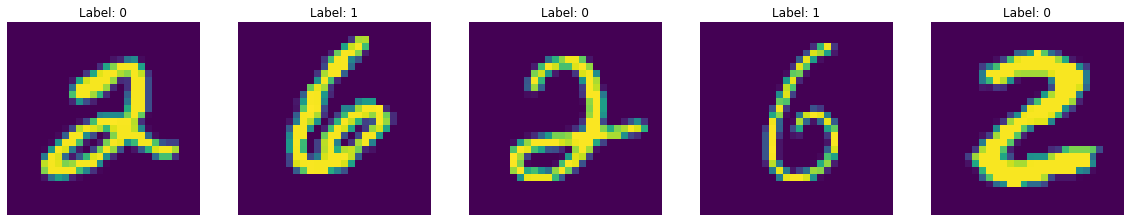

In [2]:
fig,ax  = plt.subplots(1,5,figsize=(20,10))
for i in range(5):
    ax[i].imshow(inputs[i])
    ax[i].set_title("Label: " + str(labels[i].item()))
    ax[i].axis('off')

In [3]:
# The Dataloader class handles all the shuffles for you
loader = DataLoader(data(inputs,labels), batch_size=150,shuffle=True)

In [4]:
def GPLR(Φ,t,a_0,maxIterations = 100,goalTolerance = 1e-4):
    
    N = len(t)
    A = len(a_0)
    
    a = a_0
        
    invCn = torch.linalg.inv(K(Φ,Φ))# + torch.diag(torch.ones(A)*1e-4))
    
    tolerance = 1
    iteration = 0
        
    while tolerance > goalTolerance and iteration < maxIterations:
        
        σa = torch.sigmoid(a)
        
        W = torch.diag(σa*(1 - σa))
        
        gradE = t - σa -torch.matmul(invCn,a)
        
        H = W + invCn
        
        update = torch.matmul(gradE,torch.linalg.inv(H))
        
        a = a - update
        
        tolerance = torch.sum(torch.abs(update))
        
        iteration += 1
        
    σa = torch.sigmoid(a)
        
    W = torch.diag(σa*(1 - σa))
        
    grad = t - σa
        
    H = W + invCn

    return a,H,W,grad,tolerance

def π_approx(X_test,X_train,grad):
    Kid = K(X_test,X_train)
    fstar = torch.matmul(Kid,grad)
    return torch.sigmoid(fstar)

In [5]:
for i,(inputs,labels) in enumerate(loader):
    if i == 0:
        Y_Train = labels.squeeze(dim=1)
        X_Train = inputs.squeeze(dim=1).flatten(start_dim=1)
    if i == 1: 
        Y_Test = labels.squeeze(dim=1)[:200]
        X_Test = inputs.squeeze(dim=1).flatten(start_dim=1)[:200]

In [6]:
a,H,W,grad,tolerance = GPLR(X_Train,Y_Train,torch.ones(len(X_Train)))
π = π_approx(X_Test.unsqueeze(dim=0),X_Train,grad)[0]
π[π >= 0.5] = 1
π[π < 0.5] = 0

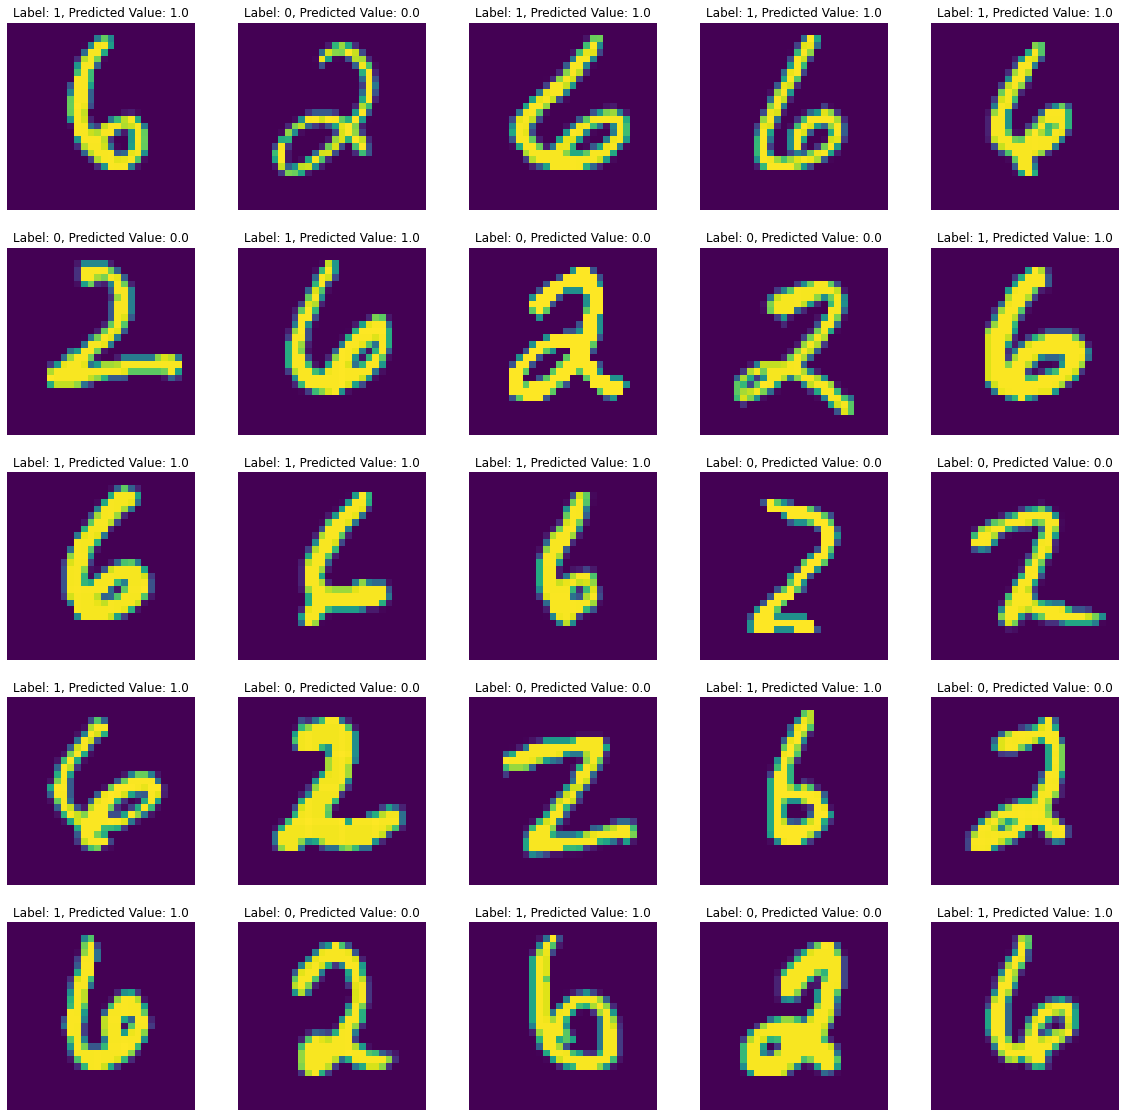

In [7]:
fig,ax  = plt.subplots(5,5,figsize=(20,20))
idx = 0
for i in range(5):
    for j in range(5):
        if Y_Test[idx].item() != π[idx].item():
            ax[j][i].imshow(X_Test[idx].reshape(28,28),cmap="inferno")
        else:
            ax[j][i].imshow(X_Test[idx].reshape(28,28))
        ax[j][i].set_title("Label: " + str(Y_Test[idx].item())  + ", Predicted Value: " + str(π[idx].item()))
        ax[j][i].axis('off')
        idx+=1

In [8]:
print("% Predictive Acccuracy: ",100 - 100*(torch.sum(torch.abs(π - Y_Test))/len(π)).item())

% Predictive Acccuracy:  94.66666653752327
